#AIT Project - Complexity Loss as a Biomarker for Alzheimer's Disease


# Setup


## Libraries


In [1]:
!pip install -q kagglehub pillow matplotlib scikit-learn seaborn


## Kaggle configuration


In [2]:
from google.colab import files
import os
import json

!mkdir -p ~/.kaggle

kaggle_credentials = {
    "username": "zaitinesnawel",
    "key": "1420cf20f7cc132b17b484f588ddfe9f"
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json

print("Kaggle authentication configured!")

Kaggle authentication configured!


## Imports


In [3]:
import numpy as np
import gzip
import bz2
import lzma
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from skimage.filters import sobel

import seaborn as sns
import kagglehub

plt.style.use('default')
sns.set_palette("husl")

# 1 - Complexity measure


In [4]:
def kolmogorov_complexity(data, method='gzip'):
    """K-complexity approximation via compression"""
    if isinstance(data, np.ndarray):
        data = data.tobytes()
    original_size = len(data)
    if original_size == 0:
        return 0.0
    if method == 'gzip':
        compressed = gzip.compress(data, compresslevel=9)
    elif method == 'bz2':
        compressed = bz2.compress(data, compresslevel=9)
    elif method == 'lzma':
        compressed = lzma.compress(data, preset=9)
    else:
        raise ValueError(f"Unknown method: {method}")
    compressed_size = len(compressed)
    return compressed_size / original_size

def conditional_complexity(image1, image2, method='gzip'):
    """Informational distance between two images"""
    if isinstance(image1, np.ndarray):
        image1 = image1.tobytes()
    if isinstance(image2, np.ndarray):
        image2 = image2.tobytes()
    cx = len(gzip.compress(image1))
    cy = len(gzip.compress(image2))
    cxy = len(gzip.compress(image1 + image2))
    nid = (cxy - min(cx, cy)) / max(cx, cy)
    return nid

def regional_complexity_map(image, grid_size=8):
    """Regional complexity map"""
    h, w = image.shape
    step_h = h // grid_size
    step_w = w // grid_size
    complexity_map = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            region = image[i*step_h:(i+1)*step_h, j*step_w:(j+1)*step_w]
            complexity_map[i, j] = kolmogorov_complexity(region)
    return complexity_map


In [5]:
def shannon_entropy(img, bins=256):
  h, _ = np.histogram(img.ravel(), bins=bins)
  p = h / h.sum()
  p = p[p>0]
  return -np.sum(p * np.log2(p))


In [6]:
def resize_image(image, scale):
    """Resizes an image by a factor"""
    h, w = image.shape
    new_h, new_w = int(h * scale), int(w * scale)
    img_pil = Image.fromarray(image)
    img_resized = img_pil.resize((new_w, new_h), Image.LANCZOS)
    return np.array(img_resized)


def extract_patches(image, size=32):
    """Extracts non-overlapping patches"""
    h, w = image.shape
    patches = []
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patches.append(image[i:i+size, j:j+size])
    return patches


def compress_ratio(data, method='gzip'):
    return kolmogorov_complexity(data, method)

# 2 - Loading the data


In [7]:
def explore_dataset_structure(dataset_path):
    """Explore the dataset structure"""
    dataset_path = Path(dataset_path)

    def print_tree(directory, prefix="", max_depth=3, current_depth=0):
        if current_depth > max_depth:
            return
        items = sorted(directory.iterdir())
        dirs = [item for item in items if item.is_dir()]
        files = [item for item in items if item.is_file()]

        for i, subdir in enumerate(dirs):
            is_last = (i == len(dirs) - 1) and len(files) == 0
            print(f"{prefix}{'└── ' if is_last else '├── '} {subdir.name}")
            img_count = len(list(subdir.glob('*.jpg'))) + len(list(subdir.glob('*.png')))
            if img_count > 0:
                print(f"{prefix}{'    ' if is_last else '│   '}    ({img_count} images)")
            new_prefix = prefix + ("    " if is_last else "│   ")
            print_tree(subdir, new_prefix, max_depth, current_depth + 1)

    print_tree(dataset_path)
    print()

def load_mri_dataset_from_kaggle():
    """Downloads and loads the dataset"""
    path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")
    print(f" Dataset downloaded to: {path}\n")
    return load_mri_dataset_from_path(path)

def load_mri_dataset_from_path(dataset_path):
    """Loads the dataset from a path"""
    dataset_path = Path(dataset_path)
    explore_dataset_structure(dataset_path)

    category_keywords = {
        'no': ('No Impairment', 0),
        'very mild': ('Very Mild Impairment', 1),
        'mild': ('Mild Impairment', 2),
        'moderate': ('Moderate Impairment', 3)
    }

    label_names = ['No Impairment', 'Very Mild Impairment',
                   'Mild Impairment', 'Moderate Impairment']

    images = []
    labels = []

    def scan_directory(directory, depth=0):
        if depth > 5:
            return
        for item in directory.iterdir():
            if item.is_dir():
                folder_name_lower = item.name.lower()
                matched = False
                for keyword, (category_name, label) in category_keywords.items():
                    if keyword in folder_name_lower:
                        img_files = list(item.glob('*.jpg')) + list(item.glob('*.png'))
                        for img_path in img_files:
                            try:
                                img = Image.open(img_path).convert('L')
                                img = img.resize((128, 128))
                                images.append(np.array(img))
                                labels.append(label)
                            except Exception as e:
                                print(f" Error: {img_path.name}")
                        if len(img_files) > 0:
                            print(f"   {category_name}: {len(img_files)} images (from {item.name})")
                        matched = True
                        break
                if not matched:
                    scan_directory(item, depth + 1)

    scan_directory(dataset_path)

    if len(images) == 0:
        print("\n No images found!")
        return np.array([]), np.array([]), label_names

    return np.array(images), np.array(labels), label_names

# 3 - Feature extraction


In [9]:
def extract_rich_features(image):
    """ Rich Features"""
    features = []

    # 1. Multi-scale compression
    for scale in [0.25, 0.5, 1.0]:
        resized = resize_image(image, scale)
        features.append(compress_ratio(resized, 'gzip'))

    # 2. Approximate anatomical regions
    h, w = image.shape
    hippocampus = image[int(h*0.5):int(h*0.8), int(w*0.3):int(w*0.7)]
    cortex = image[int(h*0.15):int(h*0.5), :]
    features.append(compress_ratio(hippocampus, 'gzip'))
    features.append(compress_ratio(cortex, 'gzip'))

    # 3. Local variability
    patches = extract_patches(image, size=32)
    if len(patches) > 0:
        patch_complexities = [compress_ratio(p, 'gzip') for p in patches]
        features.append(np.std(patch_complexities))
        features.append(np.mean(patch_complexities))
    else:
        features.extend([0, 0])

    # 4. Gradient complexity
    edges = sobel(image.astype(float))
    features.append(compress_ratio(edges.astype(np.uint8), 'gzip'))

    #shannon
    features.append(shannon_entropy(image))

    # 5. Multi-compressor ensemble
    features.append(compress_ratio(image, 'gzip'))
    features.append(compress_ratio(image, 'bz2'))
    features.append(compress_ratio(image, 'lzma'))

    return np.array(features)


def extract_complexity_features(images, verbose=True):
    """Extract features for all images"""
    features = []
    n = len(images)

    for idx, img in enumerate(images):
        #if verbose and (idx + 1) % 100 == 0:
            #print(f"   Processing: {idx+1}/{n}")
        features.append(extract_rich_features(img))

    return np.array(features)


# 4-Classification


## 4.1 - MDL


In [10]:
def mdl_classifier(X_train, y_train, X_test, verbose=True):
    """Basic MDL classifier"""
    classes = np.unique(y_train)
    prototypes = {}

    for c in classes:
        class_images = X_train[y_train == c]
        prototypes[c] = np.mean(class_images, axis=0).astype(np.uint8)
        print(f"   Class {c}: {len(class_images)} samples")

    predictions = []
    n = len(X_test)

    for idx, test_img in enumerate(X_test):
        if verbose and (idx + 1) % 50 == 0:
            print(f"   {idx+1}/{n}")

        min_complexity = float('inf')
        predicted_class = None

        for c, prototype in prototypes.items():
            complexity = conditional_complexity(test_img, prototype)

            if complexity < min_complexity:
                min_complexity = complexity
                predicted_class = c

        predictions.append(predicted_class)

    return np.array(predictions)


## 4.2 - BNN


In [11]:
def bnn_classifier(images_train, labels_train, images_test, method='gzip'):
    preds = []
    for img_test in images_test:
        min_dist = float("inf")
        best_label = None
        for img_train, label in zip( images_train, labels_train
        ):
            nid = conditional_complexity(img_test,img_train)

            if nid < min_dist:
                min_dist = nid
                best_label = label

        preds.append(best_label)

    return np.array(preds, dtype=int)


# 5 - Features Classification


## 5.1 - MDL


In [12]:
def mdl_classifier_features(X_train, y_train, X_test, verbose=True):
    """MDL classifier adapted to feature vectors"""
    classes = np.unique(y_train)
    prototypes = {c: np.mean(X_train[y_train==c], axis=0) for c in classes}

    predictions = []
    n = len(X_test)

    for idx, x in enumerate(X_test):
        if verbose and (idx+1) % 50 == 0:
            print(f"   {idx+1}/{n}")
        min_dist = float('inf')
        pred_class = None
        for c, proto in prototypes.items():
            dist = np.linalg.norm(x - proto)
            if dist < min_dist:
                min_dist = dist
                pred_class = c
        predictions.append(pred_class)

    return np.array(predictions)


## 5.2 - BNN


In [13]:
def bnn_classifier_features(X_train_features, y_train, X_test_features):
    preds = []
    for x in X_test_features:
        dists = np.linalg.norm(X_train_features - x, axis=1)
        idx_min = np.argmin(dists)
        preds.append(y_train[idx_min])
    return np.array(preds)


# 6 - Classical machine learning models


## 6.1 - Linear Regression


In [14]:
def logistic_regression_classifier(X_train, y_train, X_test):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)
  logreg = LogisticRegression(max_iter=500)
  logreg.fit(X_train_scaled, y_train)
  y_pred= logreg.predict(X_test_scaled)
  return y_pred

## 6.2 - Random Forest


In [15]:
def random_forest_classifier(X_train, y_train, X_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    return rf.predict(X_test)

## 6.3 - Gradient Boosting


In [16]:
def gradient_boosting_classifier(X_train, y_train, X_test):
    gb = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    return gb.predict(X_test)

## 6.4 - SVM


In [17]:
def svm_classifier(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train_scaled, y_train)
    return svm.predict(X_test_scaled)

# 7 - Visualisation


In [19]:
def plot_complexity_evolution(images, labels, label_names):
    """Visualizes complexity evolution"""
    complexities = []
    for idx, img in enumerate(images):
        #if (idx + 1) % 100 == 0:
            #print(f"   {idx+1}/{len(images)}")
        complexities.append(kolmogorov_complexity(img))

    complexities = np.array(complexities)

    for label, name in enumerate(label_names):
        mask = (labels == label)
        if np.sum(mask) > 0:
            mean_c = np.mean(complexities[mask])
            std_c = np.std(complexities[mask])
            #print(f"  {name}: {mean_c:.4f} ± {std_c:.4f}")

    plt.figure(figsize=(12, 6))
    colors = ['green', 'yellow', 'orange', 'red']
    for label, name in enumerate(label_names):
        mask = (labels == label)
        if np.sum(mask) > 0:
            plt.scatter(np.full(np.sum(mask), label), complexities[mask],
                       alpha=0.6, label=name, color=colors[label], s=50)

    means = [np.mean(complexities[labels == l]) for l in range(len(label_names))]
    plt.plot(range(len(label_names)), means, 'k--', linewidth=2, label='Mean trend')

    plt.xlabel('Disease Stage', fontsize=12)
    plt.ylabel('Compression Ratio (↓ = more complex)', fontsize=12)
    plt.title('Complexity Loss Across Alzheimer\'s Stages\n(AIT Hypothesis Test)', fontsize=14)
    plt.xticks(range(len(label_names)), label_names, rotation=20, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_anomaly_detection(image, label, label_name):
    """Visualizes anomaly zones"""
    comp_map = regional_complexity_map(image, grid_size=16)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'Original MRI\n{label_name}', fontsize=12)
    axes[0].axis('off')

    im = axes[1].imshow(comp_map, cmap='hot', interpolation='nearest')
    axes[1].set_title('Complexity Map\n(darker = simpler)', fontsize=12)
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    axes[1].axis('off')

    threshold = np.percentile(comp_map, 25)
    anomaly_mask = comp_map < threshold
    axes[2].imshow(image, cmap='gray')
    axes[2].imshow(anomaly_mask, cmap='Reds', alpha=0.4)
    axes[2].set_title('Low-Complexity Regions\n(Potential Atrophy)', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl, y_pred_rf, label_names, ait_text, ml_text):
    """Compares an AIT model with a classical machine learning model"""
    acc_mdl = accuracy_score(y_test, y_pred_mdl)
    acc_rf = accuracy_score(y_test, y_pred_rf)

    print(f"\n MDL Classifier (AIT-based):")
    print(f"   Accuracy: {acc_mdl:.2%}")
    print(classification_report(y_test, y_pred_mdl, target_names=label_names))

    print(f"\n Random Forest:")
    print(f"   Accuracy: {acc_rf:.2%}")
    print(classification_report(y_test, y_pred_rf, target_names=label_names))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    cm_mdl = confusion_matrix(y_test, y_pred_mdl)
    cm_rf = confusion_matrix(y_test, y_pred_rf)

    sns.heatmap(cm_mdl, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=axes[0])
    axes[0].set_title(f'{ait_text}\nAccuracy: {acc_mdl:.2%}')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_names, yticklabels=label_names, ax=axes[1])
    axes[1].set_title(f'{ml_text}\nAccuracy: {acc_rf:.2%}')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

# 8 - Main Pipeline


## 8.1 - MDL test



[1/6] LOADING DATASET


100%|██████████| 71.5M/71.5M [00:00<00:00, 101MB/s]

Extracting files...


 Dataset downloaded to: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1

└──  Combined Dataset
    ├──  test
    │   ├──  Mild Impairment
    │   │       (179 images)
    │   ├──  Moderate Impairment
    │   │       (12 images)
    │   ├──  No Impairment
    │   │       (640 images)
    │   └──  Very Mild Impairment
    │           (448 images)
    └──  train
        ├──  Mild Impairment
        │       (2560 images)
        ├──  Moderate Impairment
        │       (2560 images)
        ├──  No Impairment
        │       (2560 images)
        └──  Very Mild Impairment
                (2560 images)

   Moderate Impairment: 12 images (from Moderate Impairment)
   No Impairment: 640 images (from No Impairment)
   Mild Impairment: 179 images (from Mild Impairment)
   Very Mild Impairment: 448 images (from Very Mild Impairment)
   Moderate Impairment: 2560 images (from Moderate Impairment)
   No Impairment: 2560 images (from No Impairment)
   Mild

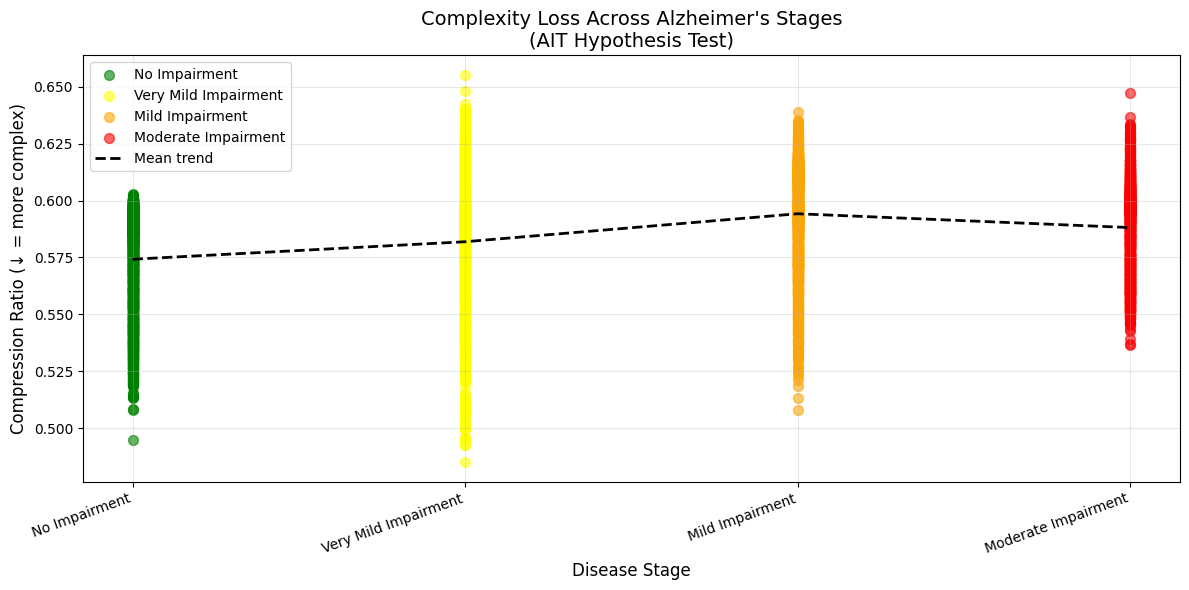


[4/6] EXTRACTING FEATURES
 Feature dimension: 12

[5/6] MDL CLASSIFICATION
   Class 0: 2560 samples
   Class 1: 2406 samples
   Class 2: 2191 samples
   Class 3: 2058 samples
   50/2304
   100/2304
   150/2304
   200/2304
   250/2304
   300/2304
   350/2304
   400/2304
   450/2304
   500/2304
   550/2304
   600/2304
   650/2304
   700/2304
   750/2304
   800/2304
   850/2304
   900/2304
   950/2304
   1000/2304
   1050/2304
   1100/2304
   1150/2304
   1200/2304
   1250/2304
   1300/2304
   1350/2304
   1400/2304
   1450/2304
   1500/2304
   1550/2304
   1600/2304
   1650/2304
   1700/2304
   1750/2304
   1800/2304
   1850/2304
   1900/2304
   1950/2304
   2000/2304
   2050/2304
   2100/2304
   2150/2304
   2200/2304
   2250/2304
   2300/2304


In [20]:
    print("\n[1/6] LOADING DATASET")
    images, labels, label_names = load_mri_dataset_from_kaggle()
    print(f"\n Total images: {len(images)}")
    print(f" Image shape: {images[0].shape}")
    print(f" Classes: {label_names}")

    print("\n[2/6] SPLITTING DATA")
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f" Train: {len(X_train)} | Test: {len(X_test)}")

    print("\n[3/6] COMPLEXITY EVOLUTION ANALYSIS")
    plot_complexity_evolution(X_train, y_train, label_names)

    print("\n[4/6] EXTRACTING FEATURES")
    X_train_features = extract_complexity_features(X_train)
    X_test_features = extract_complexity_features(X_test)
    print(f" Feature dimension: {X_train_features.shape[1]}")

    complexities = np.array([kolmogorov_complexity(img) for img in X_train])

    print("\n[5/6] MDL CLASSIFICATION")
    y_pred_mdl = mdl_classifier(X_train, y_train, X_test)

## 8.2 - ML test


In [21]:
    y_pred_lr = logistic_regression_classifier(X_train_features, y_train, X_test_features)


In [22]:
    y_pred_rf = random_forest_classifier(X_train_features, y_train, X_test_features)


In [23]:
    y_pred_gb = gradient_boosting_classifier(X_train_features, y_train, X_test_features)


In [24]:
    y_pred_svm = svm_classifier(X_train_features, y_train, X_test_features)


 MDL Classifier (AIT-based):
   Accuracy: 34.98%
                      precision    recall  f1-score   support

       No Impairment       0.29      0.53      0.37       640
Very Mild Impairment       0.40      0.09      0.15       602
     Mild Impairment       0.33      0.05      0.08       548
 Moderate Impairment       0.43      0.74      0.54       514

            accuracy                           0.35      2304
           macro avg       0.36      0.35      0.29      2304
        weighted avg       0.36      0.35      0.28      2304


 Random Forest:
   Accuracy: 65.97%
                      precision    recall  f1-score   support

       No Impairment       0.63      0.74      0.68       640
Very Mild Impairment       0.45      0.36      0.40       602
     Mild Impairment       0.70      0.66      0.68       548
 Moderate Impairment       0.84      0.91      0.88       514

            accuracy                           0.66      2304
           macro avg       0.66      0.6

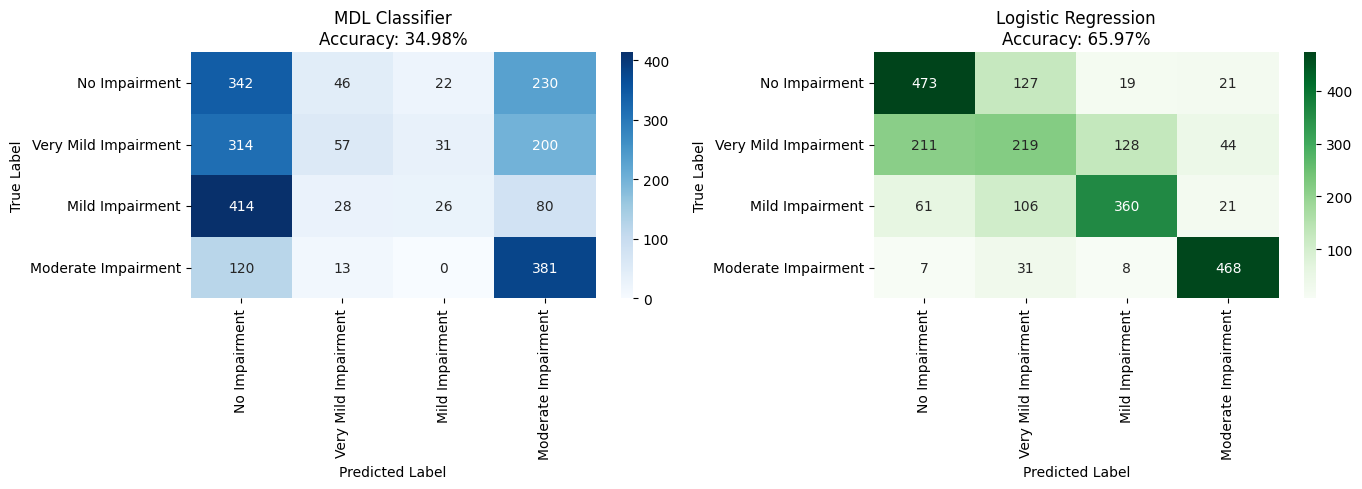


 MDL Classifier (AIT-based):
   Accuracy: 34.98%
                      precision    recall  f1-score   support

       No Impairment       0.29      0.53      0.37       640
Very Mild Impairment       0.40      0.09      0.15       602
     Mild Impairment       0.33      0.05      0.08       548
 Moderate Impairment       0.43      0.74      0.54       514

            accuracy                           0.35      2304
           macro avg       0.36      0.35      0.29      2304
        weighted avg       0.36      0.35      0.28      2304


 Random Forest:
   Accuracy: 74.78%
                      precision    recall  f1-score   support

       No Impairment       0.69      0.78      0.73       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.79      0.75      0.77       548
 Moderate Impairment       0.95      0.95      0.95       514

            accuracy                           0.75      2304
           macro avg       0.76      0.7

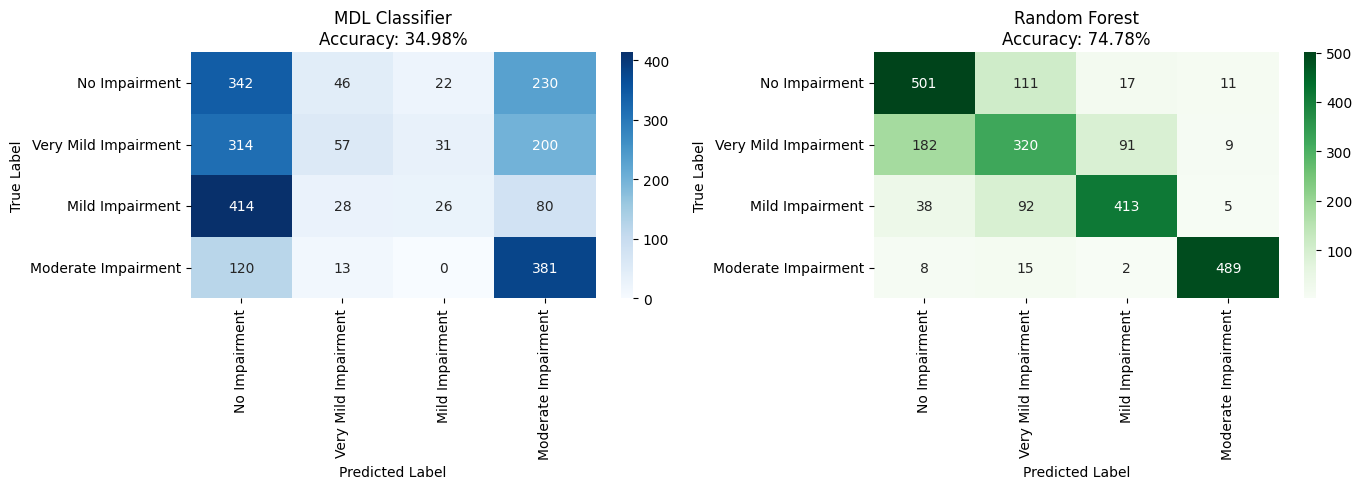


 MDL Classifier (AIT-based):
   Accuracy: 34.98%
                      precision    recall  f1-score   support

       No Impairment       0.29      0.53      0.37       640
Very Mild Impairment       0.40      0.09      0.15       602
     Mild Impairment       0.33      0.05      0.08       548
 Moderate Impairment       0.43      0.74      0.54       514

            accuracy                           0.35      2304
           macro avg       0.36      0.35      0.29      2304
        weighted avg       0.36      0.35      0.28      2304


 Random Forest:
   Accuracy: 68.01%
                      precision    recall  f1-score   support

       No Impairment       0.62      0.73      0.67       640
Very Mild Impairment       0.49      0.46      0.47       602
     Mild Impairment       0.75      0.66      0.70       548
 Moderate Impairment       0.90      0.90      0.90       514

            accuracy                           0.68      2304
           macro avg       0.69      0.6

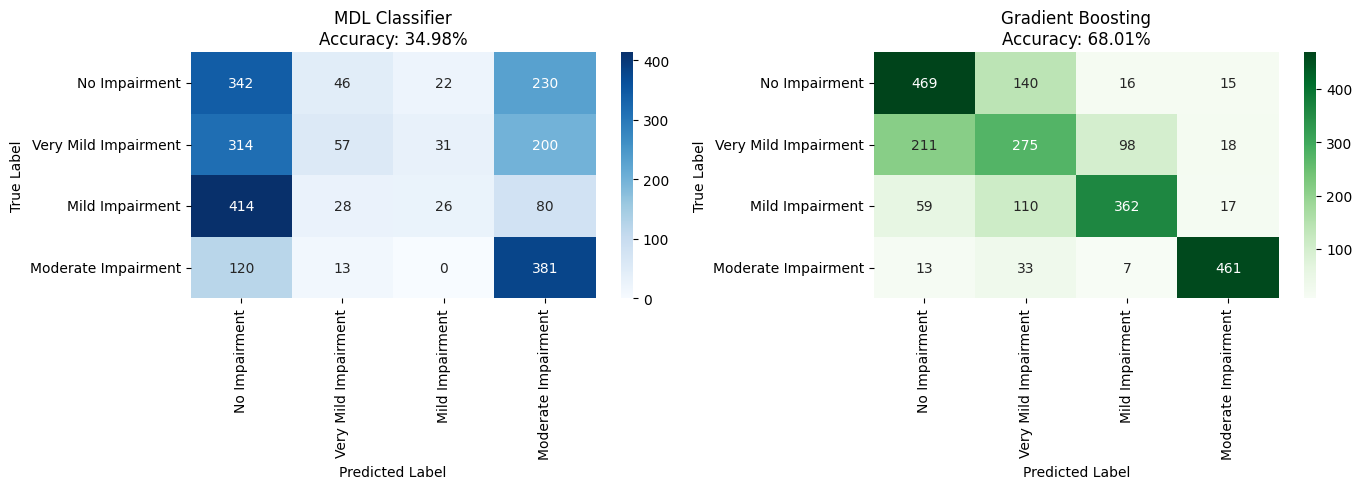


 MDL Classifier (AIT-based):
   Accuracy: 34.98%
                      precision    recall  f1-score   support

       No Impairment       0.29      0.53      0.37       640
Very Mild Impairment       0.40      0.09      0.15       602
     Mild Impairment       0.33      0.05      0.08       548
 Moderate Impairment       0.43      0.74      0.54       514

            accuracy                           0.35      2304
           macro avg       0.36      0.35      0.29      2304
        weighted avg       0.36      0.35      0.28      2304


 Random Forest:
   Accuracy: 66.54%
                      precision    recall  f1-score   support

       No Impairment       0.63      0.76      0.69       640
Very Mild Impairment       0.44      0.38      0.41       602
     Mild Impairment       0.72      0.64      0.68       548
 Moderate Impairment       0.89      0.90      0.89       514

            accuracy                           0.67      2304
           macro avg       0.67      0.6

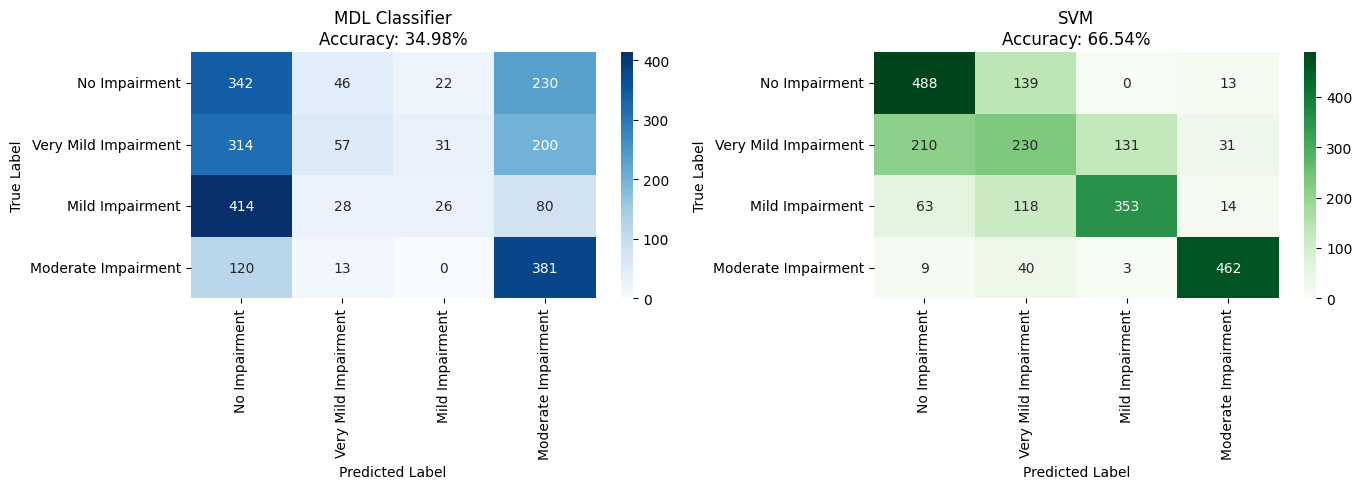

In [25]:
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                          y_pred_mdl,  y_pred_lr,label_names,"MDL Classifier","Logistic Regression")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_rf,label_names,"MDL Classifier","Random Forest")

    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_gb,label_names,"MDL Classifier","Gradient Boosting")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_svm,label_names,"MDL Classifier","SVM")

## 8.3 - MDL with CLassification features


In [26]:
print("\n[5/6] MDL CLASSIFICATION")
y_pred_mdl_features = mdl_classifier_features(X_train_features, y_train, X_test_features)


[5/6] MDL CLASSIFICATION
   50/2304
   100/2304
   150/2304
   200/2304
   250/2304
   300/2304
   350/2304
   400/2304
   450/2304
   500/2304
   550/2304
   600/2304
   650/2304
   700/2304
   750/2304
   800/2304
   850/2304
   900/2304
   950/2304
   1000/2304
   1050/2304
   1100/2304
   1150/2304
   1200/2304
   1250/2304
   1300/2304
   1350/2304
   1400/2304
   1450/2304
   1500/2304
   1550/2304
   1600/2304
   1650/2304
   1700/2304
   1750/2304
   1800/2304
   1850/2304
   1900/2304
   1950/2304
   2000/2304
   2050/2304
   2100/2304
   2150/2304
   2200/2304
   2250/2304
   2300/2304



 MDL Classifier (AIT-based):
   Accuracy: 33.98%
                      precision    recall  f1-score   support

       No Impairment       0.40      0.43      0.41       640
Very Mild Impairment       0.27      0.13      0.18       602
     Mild Impairment       0.40      0.66      0.50       548
 Moderate Impairment       0.16      0.13      0.14       514

            accuracy                           0.34      2304
           macro avg       0.31      0.34      0.31      2304
        weighted avg       0.31      0.34      0.31      2304


 Random Forest:
   Accuracy: 74.78%
                      precision    recall  f1-score   support

       No Impairment       0.69      0.78      0.73       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.79      0.75      0.77       548
 Moderate Impairment       0.95      0.95      0.95       514

            accuracy                           0.75      2304
           macro avg       0.76      0.7

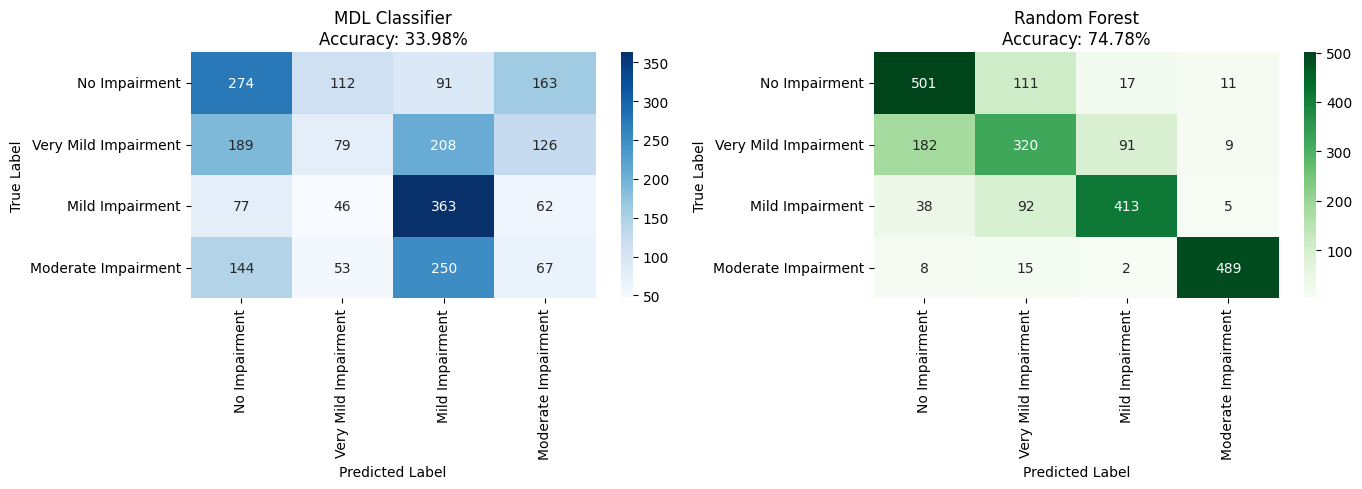

In [27]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl_features,  y_pred_rf,label_names,"MDL Classifier","Random Forest")

## 8.4 - MDL and ML with Updated Features


In [28]:
import numpy as np
from skimage.transform import resize
from skimage.filters import sobel
from skimage.measure import shannon_entropy
import gzip, bz2, lzma

def extract_grid_patches(image, grid_sizes=[4,8]):
    """Divide image into grids of multiple sizes"""
    patches = []
    h, w = image.shape
    for grid in grid_sizes:
        step_h = h // grid
        step_w = w // grid
        for i in range(grid):
            for j in range(grid):
                patch = image[i*step_h:(i+1)*step_h, j*step_w:(j+1)*step_w]
                patches.append(patch)
    return patches

def extract_rich_features_improved(image):
    features = []
    h, w = image.shape

    for scale in [0.25, 0.5, 1.0]:
        resized = resize(image, (int(h*scale), int(w*scale)), anti_aliasing=True)
        resized_uint8 = (resized*255).astype(np.uint8)
        features.append(compress_ratio(resized_uint8, 'gzip'))
        features.append(shannon_entropy(resized_uint8))
        edges = sobel(resized)
        features.append(compress_ratio((edges*255).astype(np.uint8), 'gzip'))

    # 2. Anatomical patches
    patches_anat = {
        'hippocampus': image[int(h*0.5):int(h*0.8), int(w*0.3):int(w*0.7)],
        'cortex_frontal': image[int(h*0.15):int(h*0.3), :],
        'cortex_temporal': image[int(h*0.3):int(h*0.5), :],
        'cortex_parietal': image[int(h*0.15):int(h*0.5), int(w*0.7):],
        'ventricles': image[int(h*0.45):int(h*0.55), int(w*0.45):int(w*0.55)]
    }

    for patch in patches_anat.values():
        patch_uint8 = (patch*255).astype(np.uint8)
        features.append(compress_ratio(patch_uint8, 'gzip'))
        features.append(shannon_entropy(patch_uint8))
        edges = sobel(patch)
        features.append(compress_ratio((edges*255).astype(np.uint8), 'gzip'))

    # 3. Multi-grid patches
    grid_patches = extract_grid_patches(image, grid_sizes=[4,8])
    for patch in grid_patches:
        patch_uint8 = (patch*255).astype(np.uint8)
        features.append(compress_ratio(patch_uint8, 'gzip'))
        features.append(shannon_entropy(patch_uint8))
        edges = sobel(patch)
        features.append(compress_ratio((edges*255).astype(np.uint8), 'gzip'))

    return np.array(features)

def extract_features_dataset(images, verbose=True):
    all_features = []
    for idx, img in enumerate(images):
        if verbose and (idx+1) % 50 == 0:
            print(f"Processing {idx+1}/{len(images)}")
        all_features.append(extract_rich_features_improved(img))
    return np.array(all_features)


In [29]:
print("\n[4/6] EXTRACTING FEATURES")
X_train_features = extract_features_dataset(X_train)
X_test_features = extract_features_dataset(X_test)
print(f" Feature dimension: {X_train_features.shape[1]}")

print("\n[5/6] MDL CLASSIFICATION")
y_pred_mdl = mdl_classifier(X_train_features, y_train, X_test_features)



[4/6] EXTRACTING FEATURES
Processing 50/9215
Processing 100/9215
Processing 150/9215
Processing 200/9215
Processing 250/9215
Processing 300/9215
Processing 350/9215
Processing 400/9215
Processing 450/9215
Processing 500/9215
Processing 550/9215
Processing 600/9215
Processing 650/9215
Processing 700/9215
Processing 750/9215
Processing 800/9215
Processing 850/9215
Processing 900/9215
Processing 950/9215
Processing 1000/9215
Processing 1050/9215
Processing 1100/9215
Processing 1150/9215
Processing 1200/9215
Processing 1250/9215
Processing 1300/9215
Processing 1350/9215
Processing 1400/9215
Processing 1450/9215
Processing 1500/9215
Processing 1550/9215
Processing 1600/9215
Processing 1650/9215
Processing 1700/9215
Processing 1750/9215
Processing 1800/9215
Processing 1850/9215
Processing 1900/9215
Processing 1950/9215
Processing 2000/9215
Processing 2050/9215
Processing 2100/9215
Processing 2150/9215
Processing 2200/9215
Processing 2250/9215
Processing 2300/9215
Processing 2350/9215
Proces

In [31]:
y_pred_mdl=mdl_classifier_features(X_train_features, y_train, X_test_features, verbose=True)

   50/2304
   100/2304
   150/2304
   200/2304
   250/2304
   300/2304
   350/2304
   400/2304
   450/2304
   500/2304
   550/2304
   600/2304
   650/2304
   700/2304
   750/2304
   800/2304
   850/2304
   900/2304
   950/2304
   1000/2304
   1050/2304
   1100/2304
   1150/2304
   1200/2304
   1250/2304
   1300/2304
   1350/2304
   1400/2304
   1450/2304
   1500/2304
   1550/2304
   1600/2304
   1650/2304
   1700/2304
   1750/2304
   1800/2304
   1850/2304
   1900/2304
   1950/2304
   2000/2304
   2050/2304
   2100/2304
   2150/2304
   2200/2304
   2250/2304
   2300/2304



 MDL Classifier (AIT-based):
   Accuracy: 42.19%
                      precision    recall  f1-score   support

       No Impairment       0.38      0.40      0.39       640
Very Mild Impairment       0.38      0.14      0.20       602
     Mild Impairment       0.34      0.72      0.46       548
 Moderate Impairment       0.94      0.46      0.62       514

            accuracy                           0.42      2304
           macro avg       0.51      0.43      0.42      2304
        weighted avg       0.49      0.42      0.41      2304


 Random Forest:
   Accuracy: 74.78%
                      precision    recall  f1-score   support

       No Impairment       0.69      0.78      0.73       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.79      0.75      0.77       548
 Moderate Impairment       0.95      0.95      0.95       514

            accuracy                           0.75      2304
           macro avg       0.76      0.7

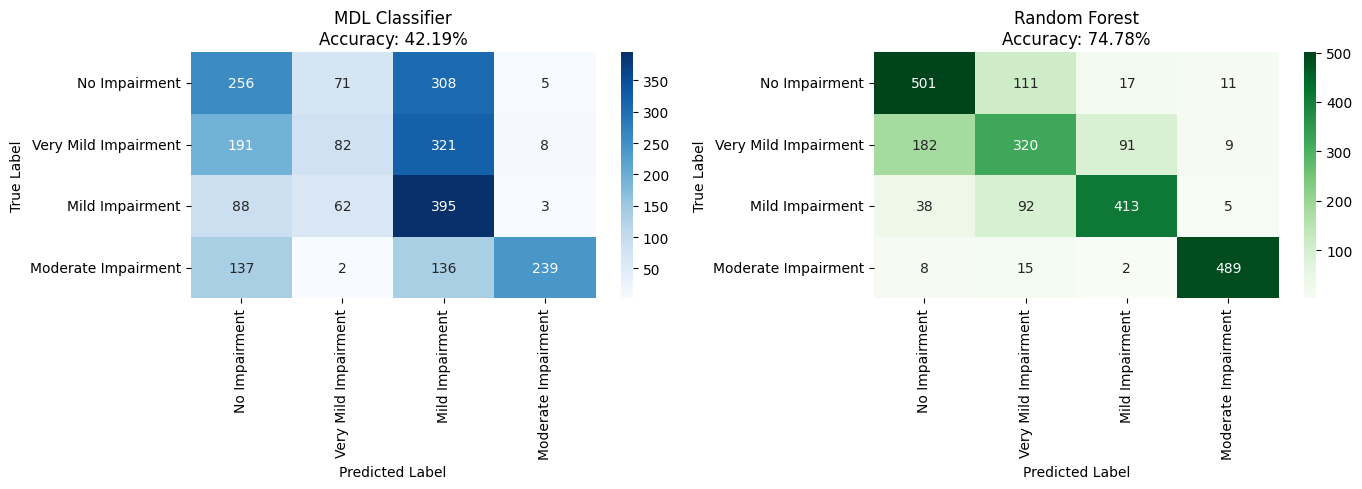

In [32]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_rf,label_names,"MDL Classifier","Random Forest")


In [33]:
y_pred_rf = random_forest_classifier(X_train_features, y_train, X_test_features)


 MDL Classifier (AIT-based):
   Accuracy: 42.19%
                      precision    recall  f1-score   support

       No Impairment       0.38      0.40      0.39       640
Very Mild Impairment       0.38      0.14      0.20       602
     Mild Impairment       0.34      0.72      0.46       548
 Moderate Impairment       0.94      0.46      0.62       514

            accuracy                           0.42      2304
           macro avg       0.51      0.43      0.42      2304
        weighted avg       0.49      0.42      0.41      2304


 Random Forest:
   Accuracy: 87.63%
                      precision    recall  f1-score   support

       No Impairment       0.77      0.93      0.84       640
Very Mild Impairment       0.82      0.79      0.80       602
     Mild Impairment       0.99      0.83      0.90       548
 Moderate Impairment       1.00      0.97      0.98       514

            accuracy                           0.88      2304
           macro avg       0.90      0.8

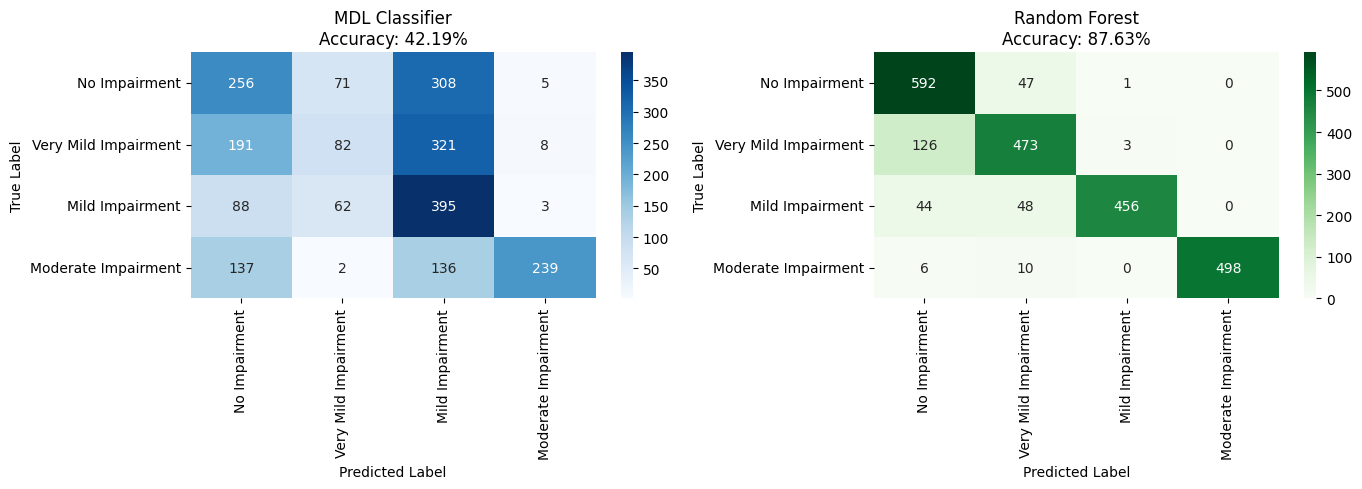

In [34]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_rf,label_names,"MDL Classifier","Random Forest")


Compression


In [35]:
def compress_len_bytes(b, method='gzip'):
    if method=='gzip':
        return len(gzip.compress(b))
    if method=='bz2':
        return len(bz2.compress(b))
    if method=='lzma':
        return len(lzma.compress(b))
    raise ValueError(method)

def normalize_to_uint8(img, clip_percentiles=(1,99)):
    # scale an image to uint8 robustly (clip to percentiles to avoid outliers)
    lo, hi = np.percentile(img, clip_percentiles)
    imgc = np.clip(img, lo, hi)
    if hi == lo:
        return np.zeros_like(imgc, dtype=np.uint8)
    scaled = ((imgc - lo) / (hi - lo) * 255.0).astype(np.uint8)
    return scaled


# 9 - Binary classification (Healthy/Impaired)


In [36]:
def merge_to_two_classes(labels):
    """
    Convert 4 ADNI labels into 2 classes:
    0 = Healthy (No + Very Mild)
    1 = Impaired (Mild + Moderate)
    """
    return np.where(labels < 2, 0, 1)

In [37]:
y_train_2 = merge_to_two_classes(y_train)
y_test_2 = merge_to_two_classes(y_test)


In [38]:
label_names_2 = ["Healthy", "Impaired"]


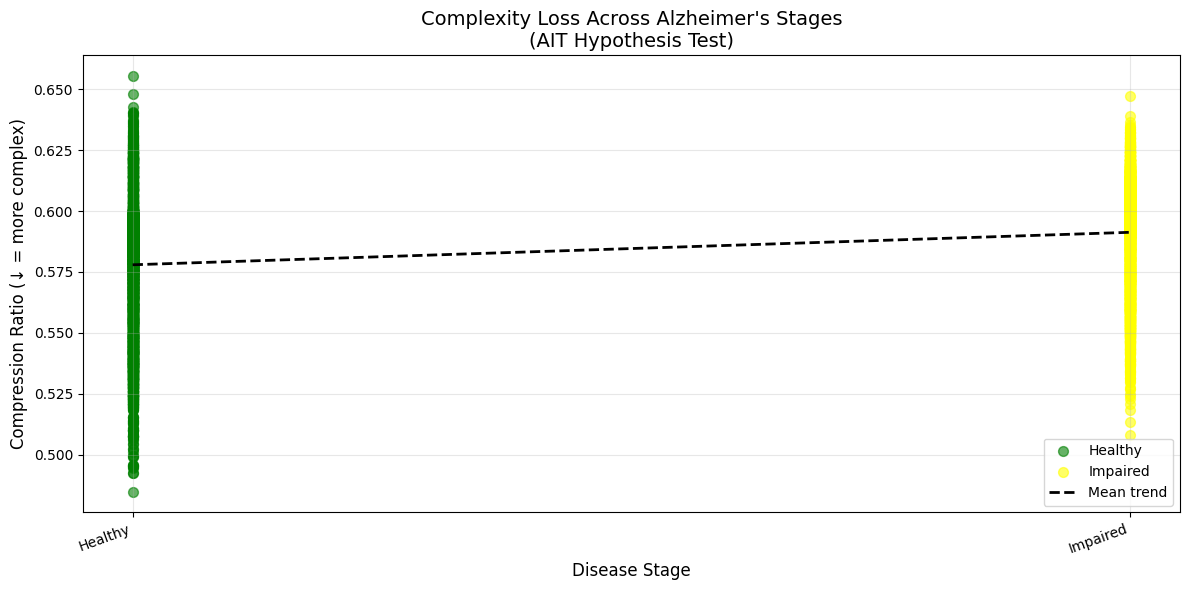

In [39]:
plot_complexity_evolution(X_train, y_train_2, label_names_2)


In [40]:
X_train_feat = extract_features_dataset(X_train)
X_test_feat  = extract_features_dataset(X_test)


Processing 50/9215
Processing 100/9215
Processing 150/9215
Processing 200/9215
Processing 250/9215
Processing 300/9215
Processing 350/9215
Processing 400/9215
Processing 450/9215
Processing 500/9215
Processing 550/9215
Processing 600/9215
Processing 650/9215
Processing 700/9215
Processing 750/9215
Processing 800/9215
Processing 850/9215
Processing 900/9215
Processing 950/9215
Processing 1000/9215
Processing 1050/9215
Processing 1100/9215
Processing 1150/9215
Processing 1200/9215
Processing 1250/9215
Processing 1300/9215
Processing 1350/9215
Processing 1400/9215
Processing 1450/9215
Processing 1500/9215
Processing 1550/9215
Processing 1600/9215
Processing 1650/9215
Processing 1700/9215
Processing 1750/9215
Processing 1800/9215
Processing 1850/9215
Processing 1900/9215
Processing 1950/9215
Processing 2000/9215
Processing 2050/9215
Processing 2100/9215
Processing 2150/9215
Processing 2200/9215
Processing 2250/9215
Processing 2300/9215
Processing 2350/9215
Processing 2400/9215
Processing 2

In [41]:
def mdl_classifier_features(X_train, y_train, X_test):
    classes = np.unique(y_train)
    prototypes = {c: np.mean(X_train[y_train==c], axis=0) for c in classes}

    return np.array([
        min(prototypes, key=lambda c: np.linalg.norm(x - prototypes[c]))
        for x in X_test
    ], dtype=int)


In [42]:
clf_lr = LogisticRegression(max_iter=2000).fit(X_train_feat, y_train_2)
pred_lr = clf_lr.predict(X_test_feat)


In [43]:
clf_rf = RandomForestClassifier(n_estimators=300).fit(X_train_feat, y_train_2)
pred_rf = clf_rf.predict(X_test_feat)


In [44]:
clf_svm = SVC(kernel="rbf", C=10, gamma="scale").fit(X_train_feat, y_train_2)
pred_svm = clf_svm.predict(X_test_feat)


In [45]:
pred_mdl = mdl_classifier_features(X_train_feat, y_train_2, X_test_feat)


In [46]:
from sklearn.metrics import classification_report, accuracy_score

models = {
    "MDL": pred_mdl,
    "Logistic Regression": pred_lr,
    "Random Forest": pred_rf,
    "SVM": pred_svm
}

for name, pred in models.items():
    print(f"{name} accuracy:", accuracy_score(y_test_2, pred))
    print(classification_report(y_test_2, pred, target_names=label_names_2))


MDL accuracy: 0.5759548611111112
              precision    recall  f1-score   support

     Healthy       0.65      0.47      0.54      1242
    Impaired       0.53      0.70      0.60      1062

    accuracy                           0.58      2304
   macro avg       0.59      0.58      0.57      2304
weighted avg       0.59      0.58      0.57      2304

Logistic Regression accuracy: 0.9058159722222222
              precision    recall  f1-score   support

     Healthy       0.88      0.96      0.92      1242
    Impaired       0.95      0.84      0.89      1062

    accuracy                           0.91      2304
   macro avg       0.91      0.90      0.90      2304
weighted avg       0.91      0.91      0.91      2304

Random Forest accuracy: 0.9405381944444444
              precision    recall  f1-score   support

     Healthy       0.90      1.00      0.95      1242
    Impaired       1.00      0.87      0.93      1062

    accuracy                           0.94      2304
   

# 10 - MDL & KMeans (Hybrid Approach)


In [47]:
from sklearn.cluster import KMeans

def mdl_kmeans_binary(X_train, y_train, X_test, n_proto=5):
    prototypes = {}
    for c in [0, 1]:
        X_c = X_train[y_train == c]
        km = KMeans(n_clusters=n_proto, random_state=42)
        prototypes[c] = km.fit(X_c).cluster_centers_

    preds = []
    for x in X_test:
        dists = {
            c: min([np.linalg.norm(x - p) for p in protos])
            for c, protos in prototypes.items()
        }
        preds.append(min(dists, key=dists.get))
    return np.array(preds)

pred_mdl_km = mdl_kmeans_binary(X_train_feat, y_train_2, X_test_feat, n_proto=5)
print(f"MDL K-Means: {accuracy_score(y_test_2, pred_mdl_km):.2%}")

MDL K-Means: 81.42%


# 11 - Feature Selection: Top 100 Features


In [49]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

selector = SelectKBest(f_classif, k=100)
X_train_sel = selector.fit_transform(X_train_feat, y_train_2)
X_test_sel = selector.transform(X_test_feat)

print(f"\nOriginal features: {X_train_feat.shape[1]}")
print(f"Selected features: {X_train_sel.shape[1]}")

# MDL
print("\n[1/4] MDL")
pred_mdl_sel = mdl_classifier_features(X_train_sel, y_train_2, X_test_sel)

# Logistic Regression
print("[2/4] Logistic Regression")
clf_lr_sel = LogisticRegression(max_iter=2000, random_state=42)
clf_lr_sel.fit(X_train_sel, y_train_2)
pred_lr_sel = clf_lr_sel.predict(X_test_sel)

# Random Forest
print("[3/4] Random Forest")
clf_rf_sel = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf_rf_sel.fit(X_train_sel, y_train_2)
pred_rf_sel = clf_rf_sel.predict(X_test_sel)

# SVM
print("[4/4] SVM")
scaler_sel = StandardScaler()
X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_sel.transform(X_test_sel)
clf_svm_sel = SVC(kernel="rbf", C=10, gamma="scale", random_state=42)
clf_svm_sel.fit(X_train_sel_scaled, y_train_2)
pred_svm_sel = clf_svm_sel.predict(X_test_sel_scaled)


models_comparison = {
    "Model": [],
    "Features": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

models_all = {
    "MDL": pred_mdl,
    "Logistic Regression": pred_lr,
    "Random Forest": pred_rf,
    "SVM": pred_svm
}

# Selected features (top 100)
models_sel = {
    "MDL": pred_mdl_sel,
    "Logistic Regression": pred_lr_sel,
    "Random Forest": pred_rf_sel,
    "SVM": pred_svm_sel
}

# Populate table
for name, pred in models_all.items():
    models_comparison["Model"].append(name)
    models_comparison["Features"].append("All")
    models_comparison["Accuracy"].append(accuracy_score(y_test_2, pred))
    models_comparison["Precision"].append(precision_score(y_test_2, pred, average='weighted'))
    models_comparison["Recall"].append(recall_score(y_test_2, pred, average='weighted'))
    models_comparison["F1-Score"].append(f1_score(y_test_2, pred, average='weighted'))

for name, pred in models_sel.items():
    models_comparison["Model"].append(name)
    models_comparison["Features"].append("Top 100")
    models_comparison["Accuracy"].append(accuracy_score(y_test_2, pred))
    models_comparison["Precision"].append(precision_score(y_test_2, pred, average='weighted'))
    models_comparison["Recall"].append(recall_score(y_test_2, pred, average='weighted'))
    models_comparison["F1-Score"].append(f1_score(y_test_2, pred, average='weighted'))

# Create DataFrame
df_results = pd.DataFrame(models_comparison)

# Format percentages
for col in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    df_results[col] = df_results[col].apply(lambda x: f"{x:.2%}")

print("\nPERFORMANCE COMPARISON TABLE")
print("=" * 80)
print(df_results.to_string(index=False))


# Best model per metric
print("\n BEST MODELS:")
df_numeric = pd.DataFrame(models_comparison)
for col in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    df_numeric[col] = df_numeric[col].astype(float)

best_acc_idx = df_numeric["Accuracy"].idxmax()
best_f1_idx = df_numeric["F1-Score"].idxmax()

print(f"  • Best Accuracy:  {df_numeric.loc[best_acc_idx, 'Model']} ({df_numeric.loc[best_acc_idx, 'Features']}) - {df_numeric.loc[best_acc_idx, 'Accuracy']:.2%}")
print(f"  • Best F1-Score:  {df_numeric.loc[best_f1_idx, 'Model']} ({df_numeric.loc[best_f1_idx, 'Features']}) - {df_numeric.loc[best_f1_idx, 'F1-Score']:.2%}")

# Feature importance (top 10)
print("\n TOP 10 MOST IMPORTANT FEATURES:")
feature_scores = selector.scores_
top_10_idx = np.argsort(feature_scores)[-10:][::-1]
for i, idx in enumerate(top_10_idx, 1):
    print(f"  {i:2d}. Feature {idx:3d} - Score: {feature_scores[idx]:.2f}")



Original features: 264
Selected features: 100

[1/4] MDL
[2/4] Logistic Regression
[3/4] Random Forest
[4/4] SVM

PERFORMANCE COMPARISON TABLE
              Model Features Accuracy Precision Recall F1-Score
                MDL      All   57.60%    59.31% 57.60%   57.16%
Logistic Regression      All   90.58%    90.94% 90.58%   90.52%
      Random Forest      All   94.05%    94.63% 94.05%   94.01%
                SVM      All   89.89%    90.73% 89.89%   89.77%
                MDL  Top 100   65.54%    67.02% 65.54%   65.39%
Logistic Regression  Top 100   89.15%    89.41% 89.15%   89.09%
      Random Forest  Top 100   93.88%    94.43% 93.88%   93.83%
                SVM  Top 100   96.18%    96.23% 96.18%   96.17%

 BEST MODELS:
  • Best Accuracy:  SVM (Top 100) - 96.18%
  • Best F1-Score:  SVM (Top 100) - 96.17%

 TOP 10 MOST IMPORTANT FEATURES:
   1. Feature  94 - Score: 6075.81
   2. Feature  93 - Score: 5984.74
   3. Feature  74 - Score: 3981.47
   4. Feature  72 - Score: 3876.87
   5.

In [50]:
from sklearn.model_selection import cross_val_score

print("\n5-Fold Cross-Validation:")
for name, clf in [('RF', clf_rf), ('LR', clf_lr), ('SVM', clf_svm)]:
    scores = cross_val_score(clf, X_train_feat, y_train_2, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean():.2%} ± {scores.std():.2%}")


5-Fold Cross-Validation:
RF: 92.77% ± 0.76%
LR: 89.91% ± 0.47%
SVM: 88.74% ± 0.76%
